---

<center><h1>ADMN5015 Artificial Intelligence in Marketing</h1>
<h2>Assignment 4: Speech-to-Text
<h3>Katrina Ong

---

**Summary**

This project aims to perform speech-to-text transcription on a sample call center audio file and conduct a sentiment analysis  on the transcription using the Google Cloud Platform (GCP).

In particular, this notebook will be analyzing the recording from this [Youtube Video](https://www.youtube.com/watch?v=IGaNOTNDYbg).

For this purpose, the following steps are implemented in this notebook: 
1. [Import Packages](#1\)-Import-Packages)
2. [Source the Data](#2\)-Source-the-Data)
3. [Prepare the Data](#3\)-Prepare-the-Data) - including converting speech to text
4. [Conduct Sentiment Analysis](#4\)-Conduct-Sentiment-Analysis)
5. [Store the Data](#5\)-Store-the-Data) - includes screenshot of database
6. [Summarize Sentiment Results](#6\)-Summarize-Sentiment-Results) - includes visualization

More details can be found in each line of code below.

---

### 1) Import Packages

In [1]:
# Importing Standard packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import os

from datetime import datetime, date, timedelta
import time
from time import strptime

In [2]:
# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set_style("whitegrid")
#sns.set_context("paper", font_scale = 2)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None # default='warn'

In [3]:
# Imports the Google Cloud libraries
from google.cloud import storage
from google.cloud import speech

In [4]:
# Importing NLP packages for Google Cloud
from google.cloud import language_v1

In [5]:
# Importing firebase libraries
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

---

### 2) Source the Data

The audio file of the call center conversation has been uploaded in Google Storage, and the code below will source the data from the appropriate bucket.

In [6]:
#CONSTANTS
BUCKET_NAME = "admn5015-class"

In [7]:
# Create environment variable for Google Cloud Storage
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "admn5015-w2023-a01afcb67ba2.json"

In [8]:
#Defining a function to list all blobs

def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    return blobs 

In [9]:
#Defining a function to extract the audio file

def extract_audio_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""

    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        audio_channel_count=2,
        language_code="en-US",
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=600)
    print("Done!")

    return response

In [10]:
# Defining a blank dataframe
df = pd.DataFrame(columns = ['sentence_number','sentence_text','transcription_date','transcription_confidence','sentiment','magnitude',])

In [11]:
# Filling in information in the dataframe which includes the transcription of the uploaded audio file 
blobs = list_blobs(BUCKET_NAME)

for blob in blobs:
    gcs_uri = "gs://" + BUCKET_NAME + "/" + blob.name
    print(f'This is the uri: {gcs_uri}')

    
    response = extract_audio_gcs(gcs_uri= gcs_uri)

# print(response)
    
    today = date.today()
    i = 0

    for result in response.results:
        new_row = {'sentence_number': i+1,
                   'sentence_text': result.alternatives[0].transcript,
                   'transcription_date': today,
                   'transcription_confidence':result.alternatives[0].confidence
                  }
        df = df.append(new_row, ignore_index=True)
        i += 1

This is the uri: gs://admn5015-class/Mock Call with a Verbally Abusive Customer (SHORT VERSION).wav
Waiting for operation to complete...
Done!


In [12]:
# Preview Dataframe
df.head(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
0,1,hi thank you for calling with John this is Can...,2023-02-05,0.9280,NaN,NaN
1,2,hi thank you for calling question this is Can...,2023-02-05,0.9747,NaN,NaN
2,3,what the actual is going on with your company...,2023-02-05,0.9501,NaN,NaN


In [13]:
# Preview Dataframe
df.tail(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
35,36,and you're incompetent camera company tell yo...,2023-02-05,0.9219,NaN,NaN
36,37,but why,2023-02-05,0.5925,NaN,NaN
37,38,I'm hoping or if you prefer the version with ...,2023-02-05,0.8750,NaN,NaN


---

### 3) Prepare the Data

In [14]:
# Preview last line 
df['sentence_text'][37]

" I'm hoping or if you prefer the version with the explanation click the link at the top right corner of this video"

In [15]:
#Remove last line since this is narration from the Youtube video
df = df.drop(index = 37)

In [16]:
# Preview first line
df['sentence_text'][0]

'hi thank you for calling with John this is Candice how may I help you this is the knowledge base of this mob call this mall call has no explanations if you prefer the version with the explanation click the link at the top right corner of this video'

In [17]:
#Remove last line since this is narration from the Youtube video
df = df.drop(index = 0)

In [18]:
# Preview dataframe
df.head(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
1,2,hi thank you for calling question this is Can...,2023-02-05,0.9747,NaN,NaN
2,3,what the actual is going on with your company...,2023-02-05,0.9501,NaN,NaN
3,4,oh let me see first of all you gave me a use ...,2023-02-05,0.9498,NaN,NaN


In [19]:
# Reset index after dropping rows
df = df.reset_index(drop=True)

In [20]:
# Preview dataframe
df.head(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
0,2,hi thank you for calling question this is Can...,2023-02-05,0.9747,NaN,NaN
1,3,what the actual is going on with your company...,2023-02-05,0.9501,NaN,NaN
2,4,oh let me see first of all you gave me a use ...,2023-02-05,0.9498,NaN,NaN


In [21]:
# Reset Sentence Number
df['sentence_number'] = df['sentence_number'] - 1

In [22]:
# Preview Datafram
df.head(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
0,1,hi thank you for calling question this is Can...,2023-02-05,0.9747,NaN,NaN
1,2,what the actual is going on with your company...,2023-02-05,0.9501,NaN,NaN
2,3,oh let me see first of all you gave me a use ...,2023-02-05,0.9498,NaN,NaN


---

### 4) Conduct Sentiment Analysis

In [23]:
# Instantiates a client
client = language_v1.LanguageServiceClient()

In [24]:
# Loop through each record

for i in range(0,len(df)):
    
    #Create Document Object
    document = language_v1.Document(content=df['sentence_text'][i], type_=language_v1.Document.Type.PLAIN_TEXT)
    
    # Detects the sentiment of the text
    sentiment = client.analyze_sentiment(request={"document": document}).document_sentiment
    
    #Get Sentiment Score and Magnitude
    df.at[i,'sentiment'] = sentiment.score
    df.at[i,'magnitude'] = sentiment.magnitude

In [25]:
# Preview Dataframe
df.head(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
0,1,hi thank you for calling question this is Can...,2023-02-05,0.9747,0.4000,0.4000
1,2,what the actual is going on with your company...,2023-02-05,0.9501,0.0000,0.0000
2,3,oh let me see first of all you gave me a use ...,2023-02-05,0.9498,-0.6000,0.6000


In [26]:
# Preview Dataframe
df.tail(3)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
33,34,and we would have gladly given you another vo...,2023-02-05,0.9603,-0.8000,0.8000
34,35,and you're incompetent camera company tell yo...,2023-02-05,0.9219,-0.5000,1.1000
35,36,but why,2023-02-05,0.5925,-0.3000,0.3000


In [27]:
# Check datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sentence_number           36 non-null     object 
 1   sentence_text             36 non-null     object 
 2   transcription_date        36 non-null     object 
 3   transcription_confidence  36 non-null     float64
 4   sentiment                 36 non-null     object 
 5   magnitude                 36 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.8+ KB


In [28]:
# Parse to Numeric
df["sentence_number"] = pd.to_numeric(df["sentence_number"])

In [29]:
# Parse to Numeric
df["sentiment"] = pd.to_numeric(df["sentiment"])

In [30]:
# Parse to Numeric
df["magnitude"] = pd.to_numeric(df["magnitude"])

In [31]:
# Parse to Datetime
df['transcription_date'] = pd.to_datetime(df['transcription_date'])

In [32]:
# Recheck datatypes of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sentence_number           36 non-null     int64         
 1   sentence_text             36 non-null     object        
 2   transcription_date        36 non-null     datetime64[ns]
 3   transcription_confidence  36 non-null     float64       
 4   sentiment                 36 non-null     float64       
 5   magnitude                 36 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 1.8+ KB


In [33]:
# See descriptive statistics of numeric features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sentence_number,36.0000,18.5000,10.5357,1.0000,9.7500,18.5000,27.2500,36.0000
transcription_confidence,36.0000,0.9261,0.0767,0.5925,0.9270,0.9516,0.9596,0.9876
sentiment,36.0000,-0.3917,0.5464,-0.9000,-0.8000,-0.6500,-0.1750,0.9000
magnitude,36.0000,0.6306,0.2734,0.0000,0.4000,0.7000,0.8000,1.1000


---

### 5) Store the Data

The transcription data will be stored in a Firestore Database (NoSQL Database).

In [34]:
# Use a service account.
cred = credentials.Certificate('admn5015-w2023-a01afcb67ba2.json')

app = firebase_admin.initialize_app(cred)

db = firestore.client()

In [35]:
# Add data to Firestore
for row in df.iterrows():
  
    doc_ref = db.collection(u'call_transcription').document() # auto generate document ID
    doc_ref.set({u'wav_filename': blob.name,
                 u'sentence_number': row[1]['sentence_number'],
                 u'sentence_text': row[1]['sentence_text'],
                 u'transcription_date': row[1]['transcription_date'],
                 u'transcription_confidence': row[1]['transcription_confidence'],
                 u'sentiment': row[1]['sentiment'],
                 u'magnitude': row[1]['magnitude']                
                })

The call data has been stored in a Firestore Database, as shown below:

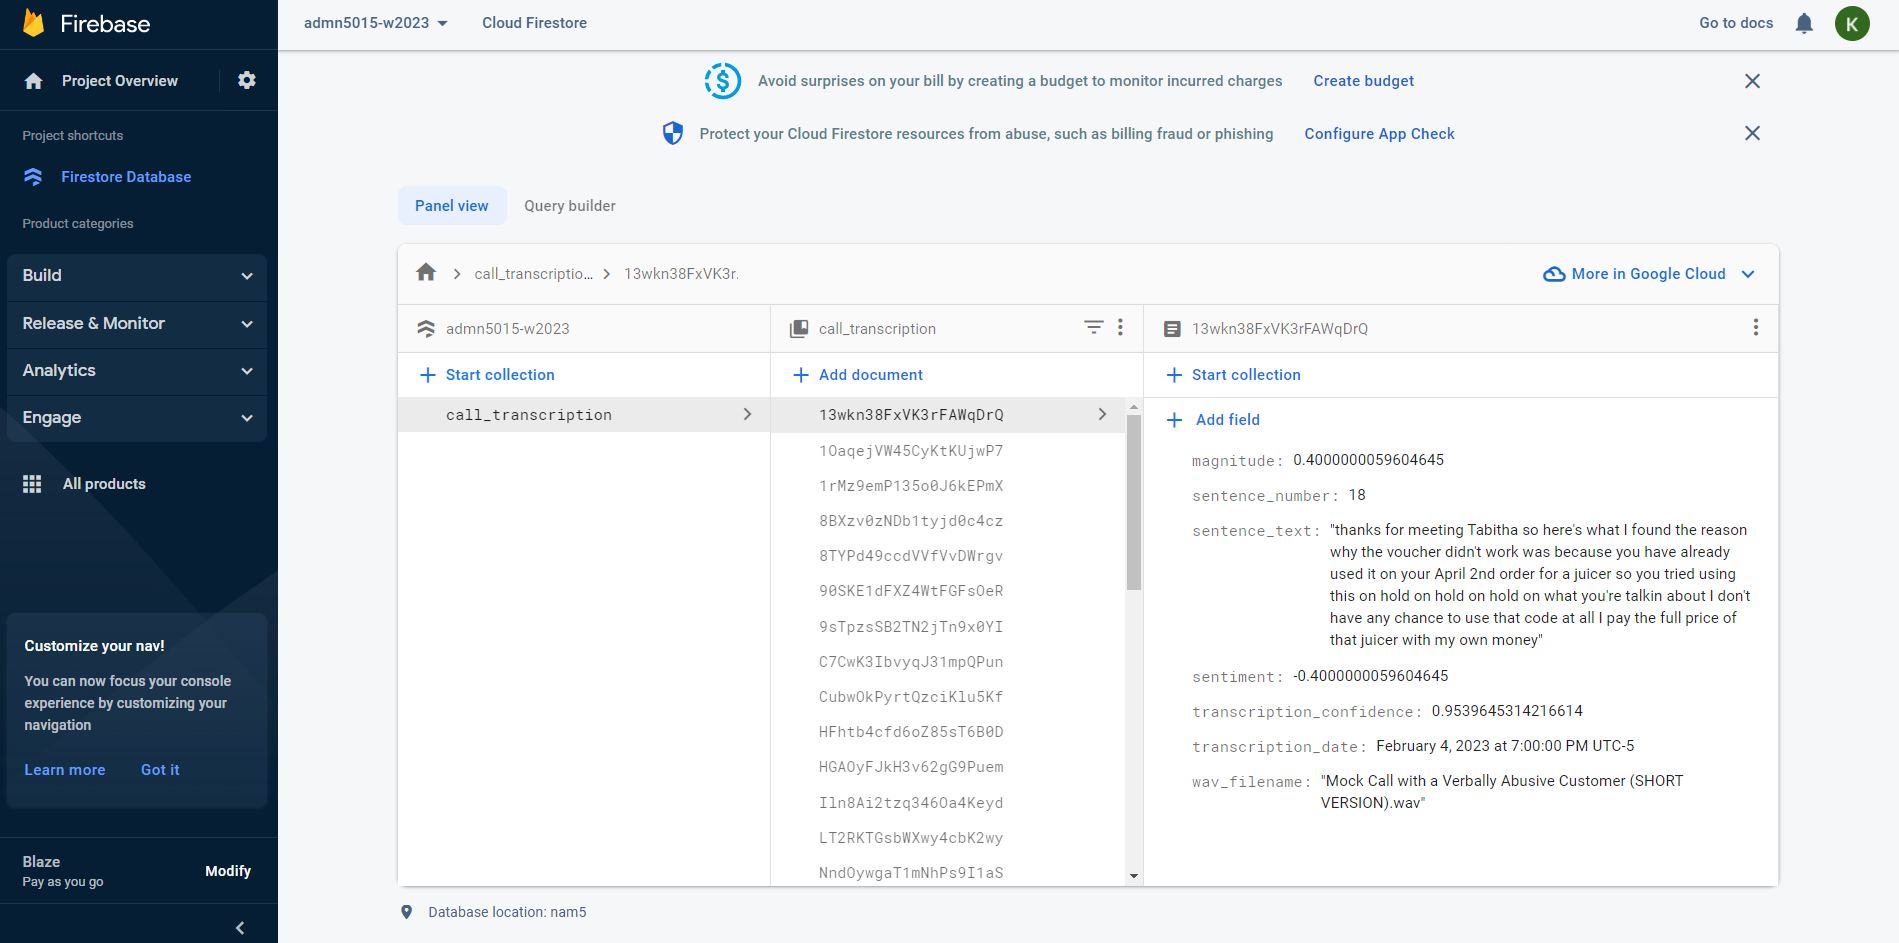

---

### 6) Summarize Sentiment Results

#### 6a) Sentiment Average

In [36]:
# Obtain the average sentiment score
ave_sentiment = df['sentiment'].mean()

In [37]:
# Obtain the average magnitude score
ave_magnitude = df['magnitude'].mean()

In [38]:
print(f'''Average Sentiment Score: {round(ave_sentiment,2)}
Average Sentiment Magnitude: {round(ave_magnitude,2)}''')

Average Sentiment Score: -0.39
Average Sentiment Magnitude: 0.63


#### 6b) Sentiment Score over the Call Duration

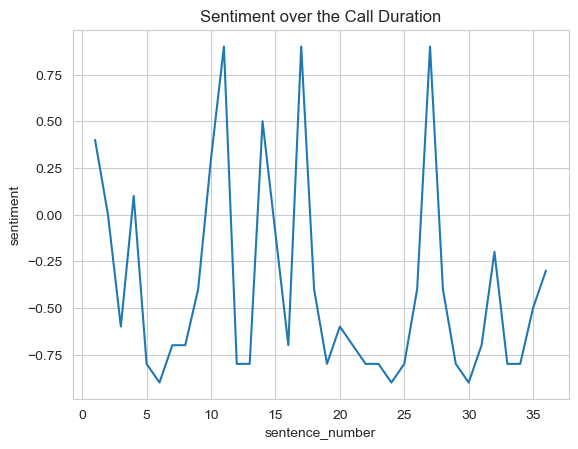

In [39]:
x = df['sentence_number']
y = df['sentiment']

sns.lineplot(x = x, y = y, data = df).set(title='Sentiment over the Call Duration');

In [41]:
# Check spikes in sentiment
df.sort_values(by = 'sentiment',ascending = False).head(10)

,sentence_number,sentence_text,transcription_date,transcription_confidence,sentiment,magnitude
10,11,thank you Tabitha,2023-02-05,0.9876,0.9000,0.9000
26,27,thanks for meeting Tabitha for me,2023-02-05,0.8392,0.9000,0.9000
16,17,fine go ahead thank you,2023-02-05,0.9822,0.9000,0.9000
13,14,yes and I'm going to do my best to help you t...,2023-02-05,0.9766,0.5000,0.5000
0,1,hi thank you for calling question this is Can...,2023-02-05,0.9747,0.4000,0.4000
9,10,Tabitha ratchet,2023-02-05,0.7363,0.3000,0.3000
3,4,second,2023-02-05,0.7897,0.1000,0.1000
1,2,what the actual is going on with your company...,2023-02-05,0.9501,0.0000,0.0000
14,15,okay what do you see,2023-02-05,0.9542,-0.1000,0.1000
31,32,tell me Candice are your mother and father co...,2023-02-05,0.9434,-0.2000,0.2000


**Interpretation**

The graph above shows that majority of the conversation had a negative sentiment score. 

Although there were some spikes in sentiment, these seem to be an indication that the call center agent remained courteous despite the negative sentiment of the customer, as shown above in the sentences with positive sentiments. 